In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

from cycler import cycler
COLORS = ['#242482', '#F00D2C', '#0071BE', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319', '#F00D2C']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

In [5]:
data = np.loadtxt('data/lec26.txt')

x = data[:, :2]
y = data[:, 2]
num_points = len(y)

# assign colors to each class
y_color = []
for i in range(num_points):
    y_color.append(COLORS[int(y[i]) + 1])

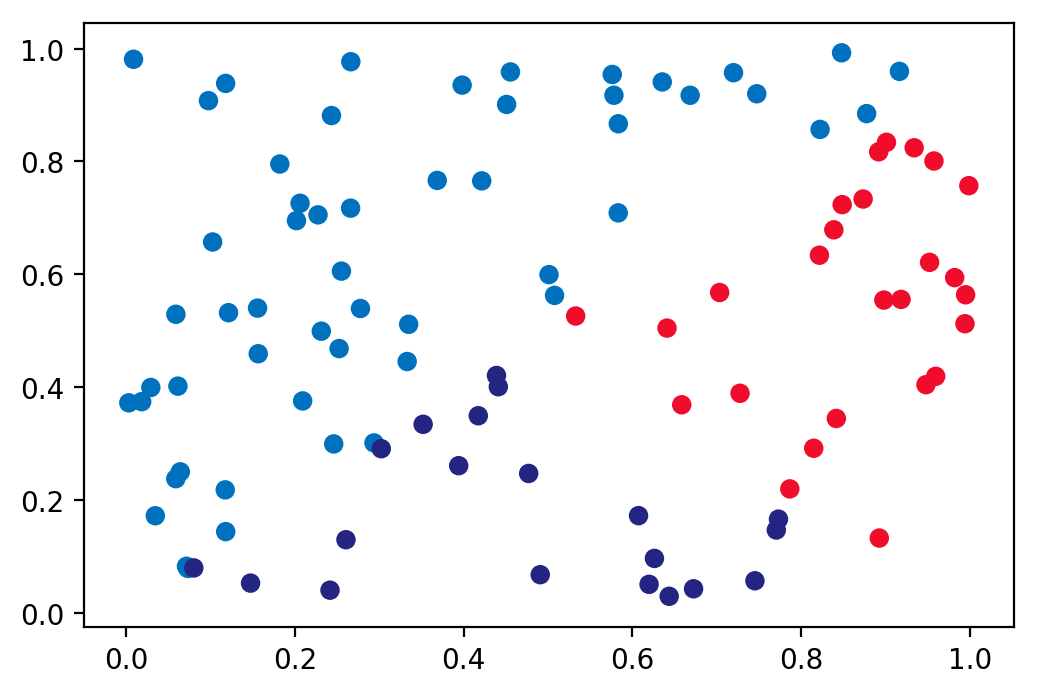

In [6]:
plt.scatter(x[:, 0], x[:, 1], c = y_color)

# Visualizing OVR and OVO

## One versus Rest

In [ ]:
I_red = y == 0
y_red = np.zeros(len(y))
y_red[I_red] = 0
y_red[~I_red] = -1

y_red_color = [COLORS[1] if in_class else '#999999' for in_class in I_red ]
plt.scatter(x[:, 0], x[:, 1], c = y_red_color)

In [ ]:
I_blue = y == 1
y_blue = np.zeros(len(y))
y_blue[I_blue] = 1
y_blue[~I_blue] = -1

y_blue_color = [COLORS[2] if in_class else '#999999' for in_class in I_blue]
plt.scatter(x[:, 0], x[:, 1], c = y_blue_color)

In [ ]:
I_purp = y == -1
y_purp = np.zeros(len(y))
y_purp[I_purp] = 1
y_purp[~I_purp] = -1

y_purp_color = [COLORS[0] if in_class else '#999999' for in_class in I_purp]
plt.scatter(x[:, 0], x[:, 1], c = y_purp_color)

# One versus One

In [ ]:
I_purp = y == -1
I_red = y == 0
I_blue = y == 1

# Purp (-1) vs Red (0)
I_p_or_r = I_purp | I_red
x_pvr = x[I_p_or_r, :]
y_pvr = y[I_p_or_r]
y_pvr_color = ['#242482' if c == -1 else '#F00D2C' for c in y_pvr]
plt.scatter(x_pvr[:, 0], x_pvr[:, 1], c = y_pvr_color)

In [ ]:
# Purp (-1) vs Blue (1)
I_p_or_b = I_purp | I_blue
x_pvb = x[I_p_or_b, :]
y_pvb = y[I_p_or_b]
y_pvb_color = ['#242482' if c == -1 else '#0071BE' for c in y_pvb]
plt.scatter(x_pvb[:, 0], x_pvb[:, 1], c = y_pvb_color)

In [ ]:
# Red (0) vs Blue (1)
I_r_or_b = I_red | I_blue
x_rvb = x[I_r_or_b, :]
y_rvb = y[I_r_or_b]
y_rvb_color = ['#F00D2C' if c == 0 else '#0071BE' for c in y_rvb]
plt.scatter(x_rvb[:, 0], x_rvb[:, 1], c = y_rvb_color)

# OVO and OVR in `sklearn`

In [7]:
num_train = int(num_points*0.8*0.8)
num_valid = int(num_points*0.8*0.2)

# Extract
x_train = x[:num_train]
y_train = y[:num_train]
    
x_valid = x[num_train:num_train+num_valid]
y_valid = y[num_train:num_train+num_valid]

x_test = x[num_train+num_valid:]
y_test = y[num_train+num_valid:]

# Normalize data
# IMPORTANT: Normalization parameters must be derived from training data
mu_x = np.mean(x_train, axis = 0)
sig_x = np.std(x_train, axis = 0)

x_train = (x_train - mu_x)/sig_x
x_valid = (x_valid - mu_x)/sig_x
x_test = (x_test - mu_x)/sig_x
x = (x - mu_x)/sig_x

In [8]:
# SVC Model do one vs one classification by itself.
from sklearn.svm import SVC

model = SVC(kernel = 'rbf', gamma = 'scale')
model.fit(x_train, y_train)
y_valid_model = model.predict(x_valid)

Alternatively, we can use the `OnevsOneClassifier` meta-model that trains several binary classifiers, no matter what the model is.

In [9]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

binary_model = SVC(kernel = 'rbf', gamma = 'scale')
model = OneVsOneClassifier(binary_model)
model.fit(x_train, y_train)
y_valid_model2 = model.predict(x_valid)

We can compare the results of the two alternatives.

In [10]:
y_valid_model == y_valid_model2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

We don't have to use SVM for our binary classification model. We could use Logistic regression, or any other classifier we've seen so far.

In [11]:
from sklearn.linear_model import LogisticRegression
binary_model = LogisticRegression(solver = 'lbfgs')
model = OneVsOneClassifier(binary_model)
model.fit(x_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   n_jobs=None)

We can also do OVR classification using the `OneVsRestClassifier` meta model.

In [12]:
from sklearn.multiclass import OneVsRestClassifier

binary_model = SVC(kernel = 'rbf', gamma = 'scale')
model = OneVsRestClassifier(binary_model)
model.fit(x_train, y_train)
y_valid_model = model.predict(x_valid)


## How do we measure performance of multi-class problem?

In [13]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
accuracy = accuracy_score(y_valid_model, y_valid)
print("Accuracy = " + str(accuracy))

Accuracy = 0.875


In [14]:
precision = precision_score(y_valid_model, y_valid, average = 'micro')
recall = recall_score(y_valid_model, y_valid, average = 'micro')

print("Precision (micro avg) = " + str(precision))
print("   Recall (micro avg) = " + str(recall))

Precision (micro avg) = 0.875
   Recall (micro avg) = 0.875
